In [21]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import os
from joblib import Parallel, delayed
import warnings
from scipy.interpolate import CubicSpline

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388
GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [10]:
sim_bi = ('142', '116', '04')
sim_uni = ('129', '116', '04')

In [4]:
def get_summary(idx, sd, sim, rmin=2, rmax=np.inf, rgal=15):
    out = {}
    key = 'lvl4-sd'+str(sd)
    output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    
    com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'_seed'+str(sd)+'.npy', allow_pickle=True).item()
    com0 = com['com0'][idx]
    
    subfname = output_dir + '/fof_subhalo_tab_'+str(idx).zfill(3)+'.hdf5'
    if not os.path.exists(subfname):
        return out
    
    snap = h5.File(output_dir + '/snapshot_'+str(idx).zfill(3)+'.hdf5', mode='r')
    NumPart_Total = snap['Header'].attrs['NumPart_Total']
    Time = snap['Header'].attrs['Time']
    out['Time'] = Time
    
    pos0 = snap['PartType0/Coordinates'][:]
    r0 = np.linalg.norm(pos0 - com0, axis=1)
    mask = np.logical_and(r0 > rmin, r0 < rmax)
    
    mass0 = snap['PartType0/Masses'][:][mask]
    sfr0 = snap['PartType0/StarFormationRate'][:][mask]
    sfgas = sfr0 > 0
    
    metals0 = snap['PartType0/GFM_Metals'][:][mask]
    FeH = metals0[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = metals0[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    out['SFR'] = np.sum(sfr0)
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH
    
    dlogFeH = 0.1
    logFeH0_list = np.arange(-1, 0.5+0.1, 0.1)
    Mgas_inFeHbin = np.zeros_like(logFeH0_list)
    SFR_inFeHbin = np.zeros_like(logFeH0_list)
    medalpha_inFeHbin = np.zeros_like(logFeH0_list)
    hiperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    loperc_alpha_inFeHbin = np.zeros_like(logFeH0_list)
    for i,logFeH0 in enumerate(logFeH0_list):
        key = np.logical_and(logFeH - logFeH0 < dlogFeH/2., logFeH - logFeH0 > -dlogFeH/2)
        key = np.logical_and(key, sfgas)
        
        Mgas_inFeHbin[i] = np.sum(mass0[key])
        SFR_inFeHbin[i] = np.sum(sfr0[key])
        if True:
            if np.sum(key) < 30:
                medalpha_inFeHbin[i] = hiperc_alpha_inFeHbin[i] = loperc_alpha_inFeHbin[i] = np.nan
            else:
                medalpha_inFeHbin[i] = np.median(logMgFe[key])
                hiperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 + 68/2)
                loperc_alpha_inFeHbin[i] = np.percentile(logMgFe[key], 50 - 68/2)
            
    
    out['Mgas_inFeHbin'] = Mgas_inFeHbin
    out['SFR_inFeHbin'] = SFR_inFeHbin
    out['medalpha_inFeHbin'] = medalpha_inFeHbin
    out['hiperc_alpha_inFeHbin'] = hiperc_alpha_inFeHbin
    out['loperc_alpha_inFeHbin'] = loperc_alpha_inFeHbin
    
    snap.close()
    
    return out

In [5]:
def get_dat_summary(sd, sim, rmin=2, rmax=np.inf, use_tqdm=False):

    if use_tqdm:
        itr = tqdm(np.arange(320+1), position=0, leave=True)
    else:
        itr = np.arange(320+1)
    
    outs = Parallel(n_jobs=64) (delayed(get_summary)(idx, sd, sim, rmin=rmin, rmax=rmax) 
                                for idx in itr)

    dat = {}
    for k in outs[0].keys():
        dat[k] = []

    for out in outs:
        for k in dat.keys():
            if k in out.keys():
                dat[k].append(out[k])
    
    for k in dat.keys():
        dat[k] = np.array(dat[k])

    return dat

In [6]:
alldat_bi = {}
alldat_uni = {}
for sd in tqdm(np.arange(16), position=0, leave=True):
    alldat_bi[sd]  = get_dat_summary(sd, sim_bi)
    alldat_uni[sd] = get_dat_summary(sd, sim_uni)

100%|██████████| 16/16 [02:06<00:00,  7.92s/it]


In [9]:
def plot_summary_sd(dat, name):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    i_Fe = 10
    
    time = dat['Time']
    sfr = dat['SFR']
    sfr_inFeHbin = dat['SFR_inFeHbin']
    
    ax.plot(time, sfr, c='k')
    ax.plot(time, sfr_inFeHbin[:,i_Fe], c=tb_c[0])
    
    ax.set(xlim=(0, 8), ylim=(0, 15))
    # ax.set_title('seed'+str(sd)+'   '+str(round(allscore[sd], 3)))
    
    fig.tight_layout()
    fig.savefig('summ_fig/'+name+'_seed'+str(sd)+'.png')

    return fig, ax

for sd in tqdm(range(16), leave=True, position=0):
    plot_summary_sd(alldat_bi[sd], 'bi')
    plt.close()
    plot_summary_sd(alldat_uni[sd], 'uni')
    plt.close()

100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


### heatmap of sfr as fn of time and feh

In [131]:
def plot_sfr_feh_time_hmap(sd):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    
    H = alldat[sd]['SFR_inFeHbin']
    extent = [0, 8, -1, 0.5]
    # im = ax.imshow(H.T, origin='lower', vmin=0, vmax=3, cmap='Greys', extent=extent)
    im = ax.imshow(H.T, origin='lower', norm=mpl.colors.LogNorm(), cmap='Greys', extent=extent)
    ax.set_aspect('auto')
    
    # print(im.get_clim())
    
    ax.set_title('seed'+str(sd)+'   '+str(round(allscore[sd], 3)))
    ax.set(xlim=(0, 8), ylim=(-1, 0.5))
    
    i_Fe = 10
    ax2 = ax.twinx()
    ax2.plot(alldat[sd]['Time'], alldat[sd]['medalpha_inFeHbin'][:,i_Fe], c=tb_c[2])
    ax2.axhline(0.31, c=tb_c[2], ls='dashed', alpha=0.5)
    ax2.set_ylim(0.15, 0.45)
    
    fig.tight_layout()
    fig.savefig('sfr_feh_time_hmap/seed'+str(sd)+'.png')
    
    return fig, ax

for sd in tqdm(range(16), leave=True, position=0):
    plot_sfr_feh_time_hmap(sd)
    plt.close()

100%|██████████| 16/16 [00:09<00:00,  1.76it/s]


### figure 1

In [29]:
def load_galaxy(sim, sd, idx=320):
    key = 'lvl4-sd'+str(sd)
    output_dir = basepath + 'runs/MW7_GSE4-Rs'+sim[0]+'-Vv'+sim[1]+'-ecc'+sim[2]+'-lvl4/' + key + '/output'
    return galaxy.Galaxy(output_dir, idx, orient=True)

def extract_sim_data(gal, sim, sd, no_SN=False):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    if no_SN:
        mask = np.full_like(in_SN, True)
    else:
        mask = in_SN
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(mask, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[mask]
    out['logMgFe'] = logMgFe[mask]
    out['GFM_StellarFormationTime'] = sn.part4.GFM_StellarFormationTime[mask]
    out['Pos'] = sn.part4.Coordinates[mask]
    out['BirthPos'] = sn.part4.BirthPos[mask]
    out['in_SN'] = in_SN
    
    # load com as fn of time
    # time, com0, com1 = find_com(sd)
    com = np.load('centering/sim_'+sim[0]+'_'+sim[1]+'_'+sim[2]+'_seed'+str(sd)+'.npy', allow_pickle=True).item()
    out['COM'] = {}
    for k in com.keys():
        out['COM'][k] = com[k]
    
    return out

In [13]:
galsd_bi = {}
galsd_uni = {}
for sd in tqdm(range(16)):
    galsd_bi[sd]  = load_galaxy(sim_bi,  sd, idx=320)
    galsd_uni[sd] = load_galaxy(sim_uni, sd, idx=320)

100%|██████████| 16/16 [01:23<00:00,  5.19s/it]


In [30]:
simdat_bi = {}
simdat_uni = {}
for sd in tqdm(range(16), leave=True, position=0):
    simdat_bi[sd]  = extract_sim_data(galsd_bi[sd],  sim_bi,  sd, no_SN=True)
    simdat_uni[sd] = extract_sim_data(galsd_uni[sd], sim_uni, sd, no_SN=True)    

100%|██████████| 16/16 [00:01<00:00, 14.04it/s]


In [23]:
def plot_age_hist(dat, sd, name, logFeH0=0, dlogFeH=0.1):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    
    logFeH = dat['logFeH']
    tform = dat['GFM_StellarFormationTime']
    
    time = dat['COM']['time']
    com0 = dat['COM']['com0']
    spl = CubicSpline(time, com0)
    BirthPos = dat['BirthPos']
    com0_attform = spl(tform)
    r0_attform = np.linalg.norm(BirthPos - com0_attform, axis=1)
    mask = r0_attform > 2
    
    key = np.logical_and(logFeH > logFeH0-dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    key = np.logical_and(key, mask)
    
    tbins = np.arange(0, 8+0.05, 0.05)
    ax.hist(tform[key], bins=tbins, histtype='step', density=True)
    
    # ax.set_title('seed'+str(sd)+'   '+str(round(allscore[sd], 3)))
    ax.set(xlim=(0, 8), ylim=(0, 0.4))
    
    fig.tight_layout()
    fig.savefig('age_hist/'+name+'_seed'+str(sd)+'.png')
    
    return fig, ax

for sd in tqdm(range(16), leave=True, position=0):
    plot_age_hist(simdat_bi[sd], sd, 'bi')
    plt.close()
    plot_age_hist(simdat_uni[sd], sd, 'uni')
    plt.close()

100%|██████████| 16/16 [00:15<00:00,  1.03it/s]


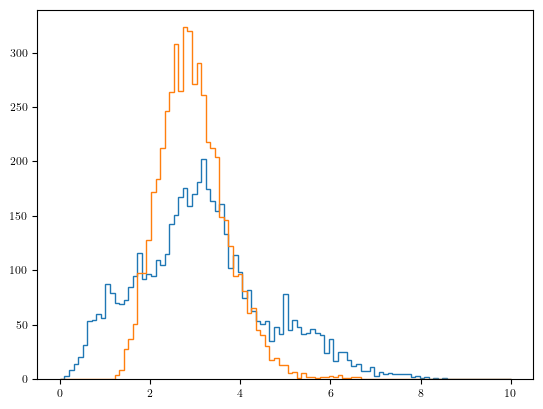

In [32]:
dat = simdat_uni[0]

logFeH0 = 0
dlogFeH = 0.1

logFeH = dat['logFeH']
tform = dat['GFM_StellarFormationTime']
    
time = dat['COM']['time']
com0 = dat['COM']['com0']
spl = CubicSpline(time, com0)
BirthPos = dat['BirthPos']
Pos = dat['Pos']
com0_attform = spl(tform)
r0_attform = np.linalg.norm(BirthPos - com0_attform, axis=1)
r0_atend = np.linalg.norm(Pos - com0[-1], axis=1)
    
mask = np.logical_and(logFeH > logFeH0-dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
mask = np.logical_and(mask, dat['in_SN'])

plt.hist(r0_attform[mask], bins=np.linspace(0, 10, 100), histtype='step');
plt.hist(r0_atend[mask], bins=np.linspace(0, 10, 100), histtype='step');

In [38]:
def plot_fig1(simdat, vmax=1e6):
    fig, axs = plt.subplots(3, 1, figsize=(columnwidth, 1.5*columnwidth))

    N_FeH = 125
    N_MgFe = 125

    def plot_panel(data, fig, ax0, ax1, ax2, logFeH_lim, logMgFe_lim, logFeH0_list, 
                   offset=-0.3, doffset = 0.4, poffset=0.4, vmax=1e5):
        logFeH = data['logFeH']
        logMgFe = data['logMgFe']
        tform = data['GFM_StellarFormationTime']
        
        time = data['COM']['time']
        com0 = data['COM']['com0']
        spl = CubicSpline(time, com0)
        BirthPos = data['BirthPos']
        com0_attform = spl(tform)
        r0_attform = np.linalg.norm(BirthPos - com0_attform, axis=1)
        # mask = np.logical_and(r0_attform > 2, tform < 5)
        mask = np.full_like(r0_attform, True, dtype=bool)
    
        FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
        MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
        dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
        dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
        wts = np.ones(len(logFeH))/dFeH/dMgFe
        
        H, _, _, _ = binned_statistic_2d(logFeH[mask], logMgFe[mask], 
                                         wts[mask],
                                         statistic='sum', bins=[FeH_bins, MgFe_bins])
    
        im = ax0.imshow(H.T, origin='lower', extent=[logFeH_lim[0],  logFeH_lim[1],
                                                     logMgFe_lim[0], logMgFe_lim[1]],
                           cmap='Greys', vmin=0, vmax=vmax)
        
        x = np.linspace(logFeH_lim[0], logFeH_lim[1], 1000)
        y = -0.1*x + 0.31
        ax0.plot(x, y, c='k', ls='dashed')
    
        ax0.set(xlim=logFeH_lim, ylim=logMgFe_lim)
        ax0.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
        ax0.set(aspect='auto')
    
        dlogFeH0 = 0.1
        d = 0.25/2
        offset_list = [d, 0.25+d, 0.5+d, 0.75+d]
        
        wts = np.full_like(logFeH, 1.)
        
        for i,(logFeH0, c) in enumerate(zip(logFeH0_list, [tb_c[0], tb_c[1], tb_c[2], tb_c[4]])):
            offset = offset_list[i]
            key = np.logical_and(logFeH > logFeH0 - dlogFeH0/2., logFeH < logFeH0 + dlogFeH0/2.)
            key = np.logical_and(key, mask)
        
            bins = np.linspace(-d/2, 1+d/2, 200+1)
            binsplot = 0.5*(bins[1:] + bins[:-1])
            hist, _ = np.histogram(logMgFe[key]-np.median(logMgFe[key])+offset, 
                                   bins=bins, density=True, weights=wts[key])
            l = ax1.plot(binsplot, hist, c=c, lw=1)
    
            ax0.axvline(logFeH0, c=l[0].get_color())
        
            if i==1 or i==2:
                ax2.hist(data['GFM_StellarFormationTime'][key], bins=np.linspace(0, 5, 80),
                         histtype='step', color=c, weights=wts[key])
        
            offset += doffset
    
        ax1.set(ylim=(0, 20), xlim=(-d/2, 1+d/2))
        ax1.set(xlabel=r'$[\textrm{Mg}/\textrm{Fe}] + \textrm{ offset}$')
    
    logFeH0_list=[-0.5, -0.25, 0, 0.25]
    plot_panel(simdat, fig, axs[0], axs[1], axs[2], (-1, 0.5), (0.1, 0.65), logFeH0_list, 
               doffset=0.3, poffset=0.1, vmax=vmax)
    
    axs[0].set_xticks(np.arange(-1, 0.5+0.1, 0.1), minor=True)
    axs[0].set_yticks(np.arange(0.1, 0.7+0.1, 0.1))
    
    axs[2].set_xlim(0, 5)
    axs[2].set_xlabel(r'$\textrm{stellar formation time}$')
    
    fig.tight_layout()
    
    return fig, axs


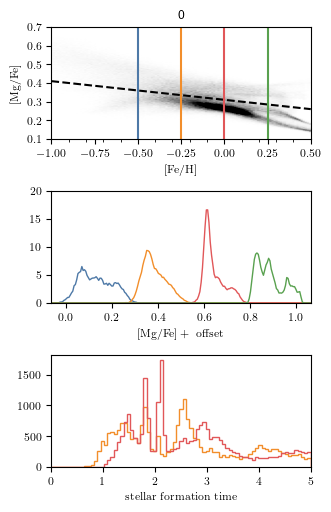

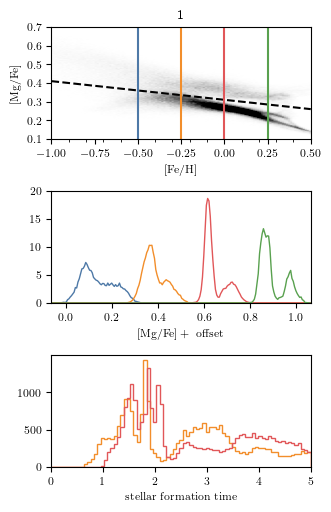

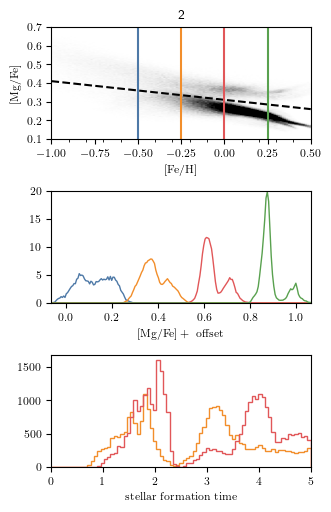

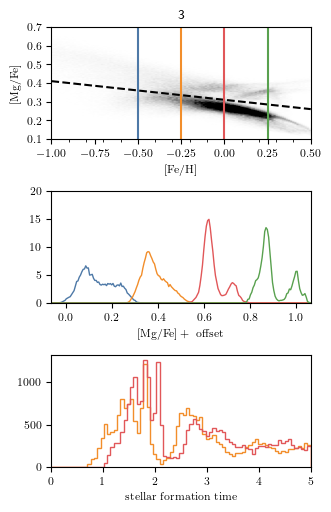

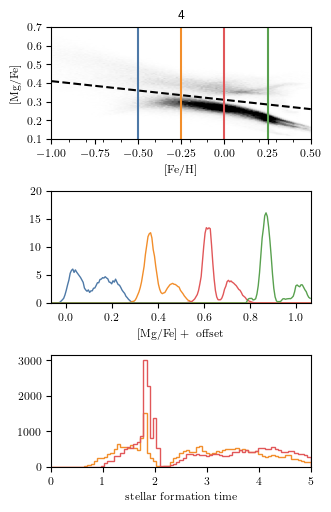

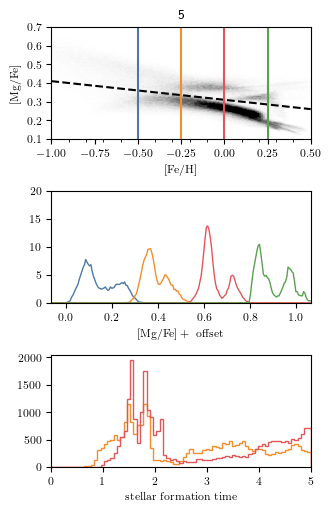

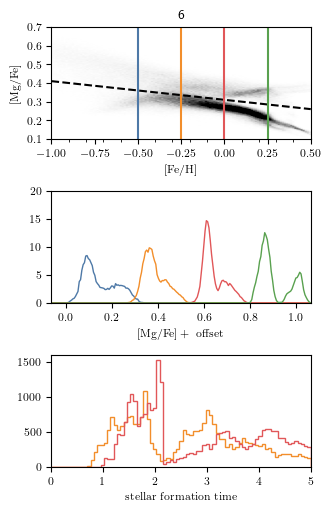

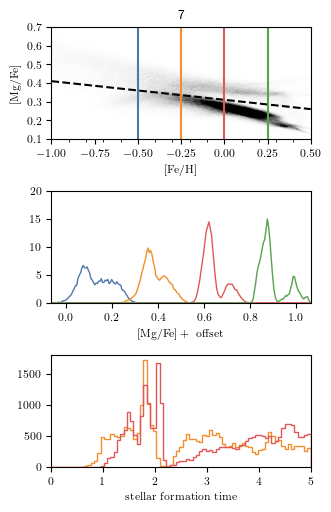

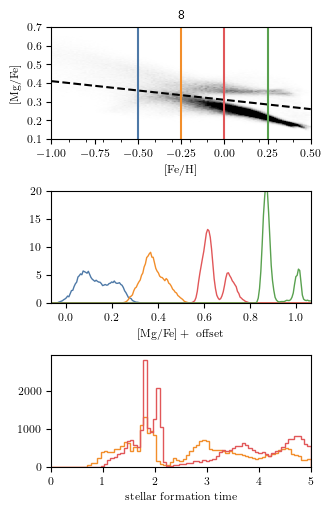

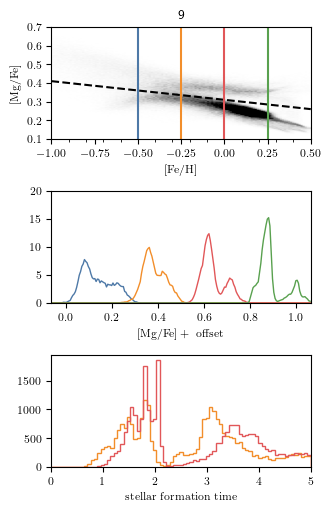

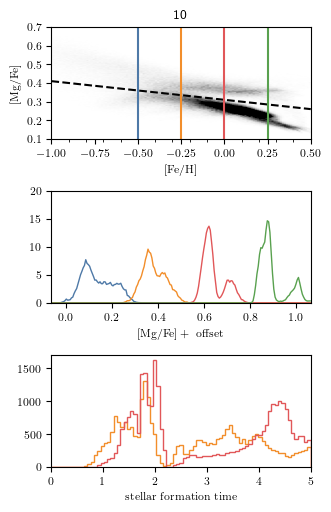

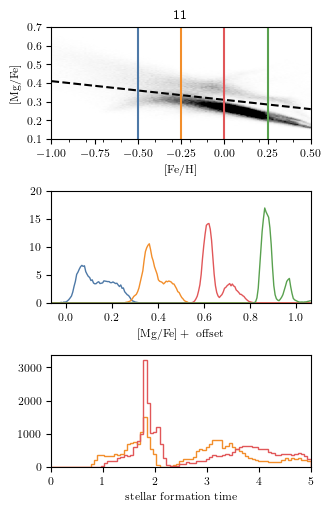

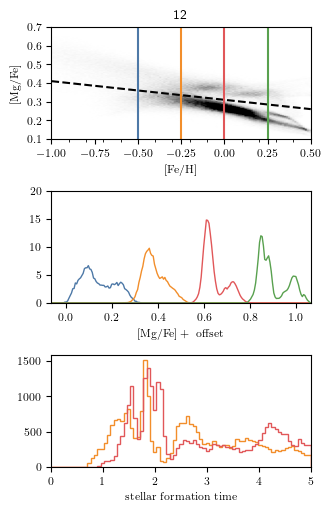

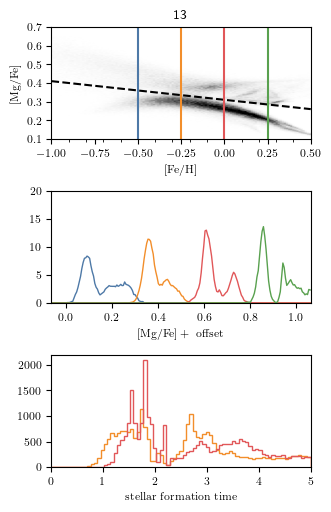

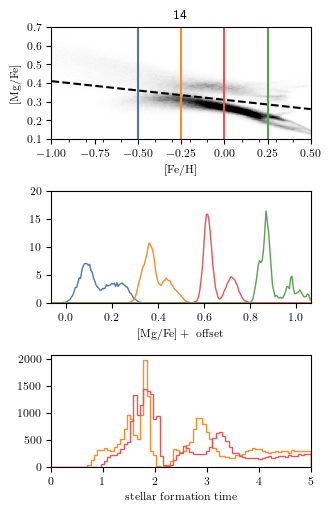

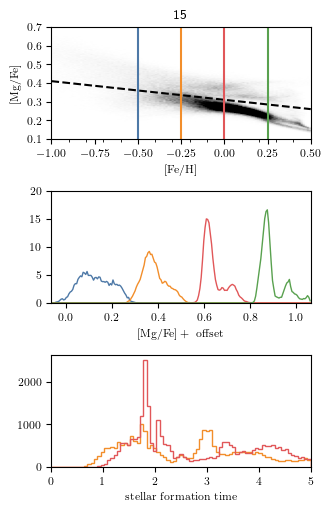

In [39]:
for i in range(16):
    fig, axs = plot_fig1(simdat_uni[i], vmax=5e6)
    axs[0].set_title(str(i))
    
    fig.savefig('fig1/seed'+str(i)+'.pdf')

# simdat 7 high and low alpha formation times

In [99]:
from scipy.interpolate import CubicSpline

In [100]:
time, com0, com1 = find_com(7)
spl = CubicSpline(time, com0)

100%|██████████| 321/321 [00:03<00:00, 98.96it/s] 


[(0.0, 250.0)]

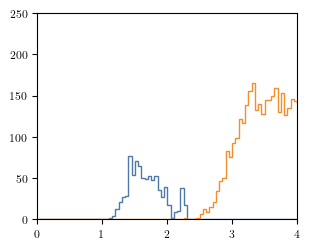

In [106]:
logFeH0 = 0
dlogFeH = 0.1

logFeH = simdat[7]['logFeH']
logMgFe = simdat[7]['logMgFe']
tform = simdat[7]['GFM_StellarFormationTime']
BirthPos = simdat[7]['BirthPos']

com0_attform = spl(tform)
r0_attform = np.linalg.norm(BirthPos - com0_attform, axis=1)
mask = r0_attform > 2

key_Fe = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
key_Fe = np.logical_and(mask, key_Fe)
high_alpha = np.logical_and(key_Fe, logMgFe > -0.1*logFeH + 0.31)
low_alpha = np.logical_and(key_Fe, logMgFe < -0.1*logFeH + 0.31)

fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
ax.hist(tform[high_alpha], bins=np.arange(0, 8+0.05, 0.05), color=tb_c[0], histtype='step');
ax.hist(tform[low_alpha], bins=np.arange(0, 8+0.05, 0.05), color=tb_c[1], histtype='step');
ax.set(xlim=(0, 4))
ax.set(ylim=(0, 250))

In [38]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.integrate import quad

def construct_gmm(dat, logFeH0=0, dlogFeH=0.2):
    """
    Analyze peaks in the logMgFe data for a given seed number `sd`.

    Parameters:
        simdat (dict): Dictionary containing simulated data.
        sd (int): Seed number for the simulation.
        logFeH0 (float): Central logFeH value to filter data around.
        dlogFeH (float): Range of logFeH to filter data.
        
    Returns:
        peak_heights (list): Heights of each Gaussian peak.
        peak_distance (float): Distance between the centers of the peaks.
    """
    # Extract the data for the given seed
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    
    # Filter data based on logFeH
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2, logFeH < logFeH0 + dlogFeH / 2)
    data = logMgFe[key].reshape(-1, 1)

    # Fit a Gaussian Mixture Model
    gmm = GaussianMixture(n_components=2, random_state=0)
    gmm.fit(data)
    
    return gmm

def calculate_overlap(mean1, std1, mean2, std2):
    """
    Calculate the overlap between two Gaussian distributions.
    
    Parameters:
        mean1, std1: Mean and standard deviation of the first Gaussian.
        mean2, std2: Mean and standard deviation of the second Gaussian.
        
    Returns:
        overlap (float): The overlap between the two distributions.
    """
    def pdf1(x):
        return norm.pdf(x, loc=mean1, scale=std1)
    
    def pdf2(x):
        return norm.pdf(x, loc=mean2, scale=std2)
    
    def min_pdf(x):
        return np.minimum(pdf1(x), pdf2(x))
    
    # Integrate the minimum of the two PDFs
    overlap, _ = quad(min_pdf, -np.inf, np.inf)
    return overlap

def bimodality_metric(gmm):
    """
    Calculate a bimodality metric based on the ratio of the less prominent mode's peak 
    to the trough between the two modes.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
    
    Returns:
        bimodality_score (float): The calculated bimodality metric.
    """
    # Extract GMM parameters
    means = gmm.means_.flatten()
    variances = gmm.covariances_.flatten()
    weights = gmm.weights_

    # Ensure components are ordered by mean
    order = np.argsort(means)
    means = means[order]
    variances = variances[order]
    weights = weights[order]

    # Calculate the peaks (heights of the modes)
    peaks = weights / np.sqrt(2 * np.pi * variances)
    less_prominent_peak = min(peaks)

    # Find the trough: point between means where the GMM density is minimized
    x_trough = np.linspace(means[0], means[1], 1000)
    densities = np.exp(gmm.score_samples(x_trough.reshape(-1, 1)))
    trough_density = densities.min()

    # Compute the bimodality metric
    bimodality_score = less_prominent_peak / trough_density
    return bimodality_score

# Example usage:
# Assuming `simdat` is defined and contains the appropriate data
gmm = construct_gmm(simdat[2], logFeH0=0.0, dlogFeH=0.1)
bimodality_metric(gmm)

1.590283354232974

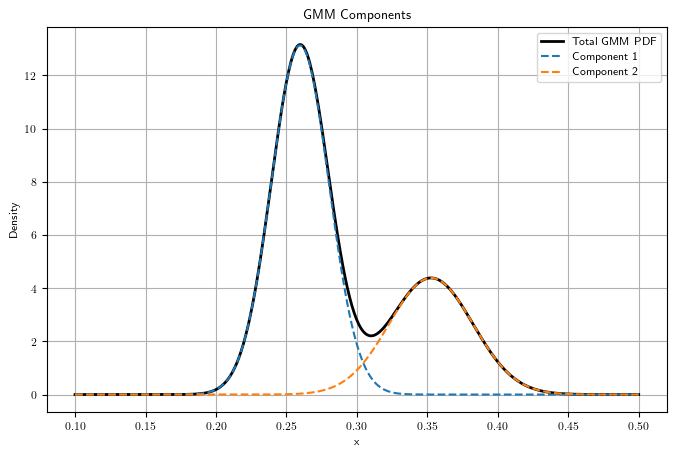

1.9867466857770066


In [303]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

def plot_gmm_components(gmm, xrange=(0.1, 0.5), num_points=500):
    """
    Plots the components of a Gaussian Mixture Model over a specified range.
    
    Parameters:
        gmm: A fitted GaussianMixture object from sklearn.
        xrange (tuple): Range of x values for the plot (default: (0.1, 0.5)).
        num_points (int): Number of points to sample in the range (default: 500).
    """
    # Generate x values in the specified range
    x = np.linspace(xrange[0], xrange[1], num_points).reshape(-1, 1)
    
    # Calculate the GMM's total density and individual component densities
    total_density = np.exp(gmm.score_samples(x))
    responsibilities = gmm.predict_proba(x)
    component_densities = responsibilities * total_density[:, np.newaxis]
    
    # Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(x, total_density, label="Total GMM PDF", linewidth=2, color='black')
    for i, density in enumerate(component_densities.T):
        plt.plot(x, density, linestyle='--', label=f"Component {i+1}")
    
    plt.title("GMM Components")
    plt.xlabel("x")
    plt.ylabel("Density")
    plt.legend()
    plt.grid()
    plt.show()

# Example usage:
# Assuming `gmm` is a fitted GaussianMixture object:
gmm = construct_gmm(simdat[9], logFeH0=0.0, dlogFeH=0.1)
score = bimodality_metric(gmm)
plot_gmm_components(gmm)
print(score)

In [39]:
allgmm = {}
allscore = np.zeros(16)
for sd in np.arange(16):
    allgmm[sd] = construct_gmm(simdat[sd], logFeH0=0.0, dlogFeH=0.1)
    allscore[sd] = bimodality_metric(allgmm[sd])

In [305]:
allscore[has_bimodal]

array([2.39925998, 5.8709892 , 2.39495101, 2.91273134, 3.98338195,
       2.48150245])

In [306]:
not_bimodal = np.full(16, True)
not_bimodal[has_bimodal] = False
allscore[not_bimodal]

array([1.2531785 , 1.59028335, 1.12186921, 3.7168479 , 1.71543664,
       1.54046365, 1.98674669, 3.10746304, 2.44466842, 1.1355906 ])

In [239]:
np.where(not_bimodal)[0][6]

9

In [168]:
allscore[np.argsort(allscore)]

array([0.34160817, 0.36898537, 0.4130601 , 0.46449243, 0.56508695,
       0.65309462, 0.72986587, 0.73821282, 0.80026763, 0.82025058,
       1.08933472, 1.16452867, 1.16932868, 1.32791088, 1.43095689,
       1.80419357])

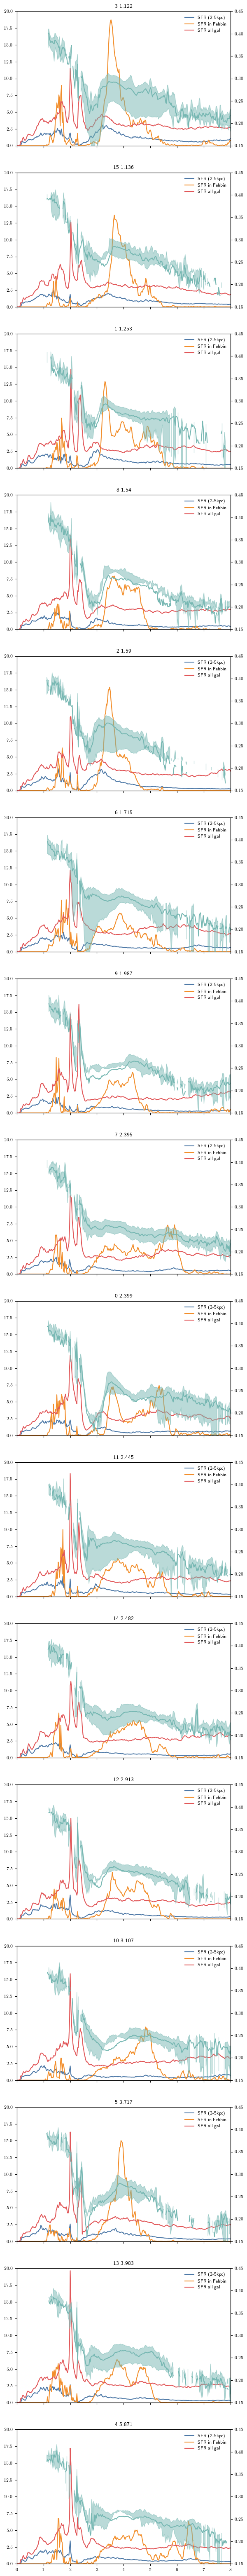

In [307]:
fig, axs = plt.subplots(16, 1, figsize=(2*columnwidth, 2*12*columnwidth), sharex=True, sharey=True)

i_Fe = 10

# this is based on plots w/ fiducial sfr
has_bimodal = [0, 4, 7, 12, 13, 14]
sfr_fac = 1

# this is based on plots w/ enhanced sfr
# has_bimodal = [0, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
# sfr_fac = 3

for i in alldat.keys():
    sd = np.argsort(allscore)[i]
    
    glob_sfr = np.copy(alldat[sd]['globalSFR'])
    glob_sfr[alldat[sd]['Time'] < 2] *= sfr_fac
    
    sfr = np.copy(alldat[sd]['SFR'])
    sfr[alldat[sd]['Time'] < 2] *= sfr_fac
    
    sfr_inbin = alldat[sd]['SFR_inFeHbin'][:,i_Fe]/0.05
    sfr_inbin[alldat[sd]['Time'] < 2] *= sfr_fac
    
    axs[i].plot(alldat[sd]['Time'], sfr, c=tb_c[0], label='SFR (2-5kpc)')
    # axs[i].plot(alldat[sd]['Time'], alldat[sd]['Mgas']/alldat[i]['SFR'], c=tb_c[2])
    axs[i].plot(alldat[sd]['Time'], sfr_inbin, c=tb_c[1], label='SFR in Fehbin')
    axs[i].plot(alldat[sd]['Time'], glob_sfr, c=tb_c[2], label='SFR all gal')
    
    ax2 = axs[i].twinx()
    ax2.set(ylim=(0.15, 0.45))
    
    ax2.plot(alldat[i]['Time'], alldat[sd]['medalpha_inFeHbin'][:,i_Fe], c=tb_c[3], label='med alpha in bin')
    ax2.fill_between(alldat[sd]['Time'], alldat[i]['loperc_alpha_inFeHbin'][:,i_Fe], 
                     alldat[sd]['hiperc_alpha_inFeHbin'][:,i_Fe], color=tb_c[3], alpha=0.5)
    
    # if i in has_bimodal:
        # axs[i].set_title(str(i)+' bimodal')
    # else:
        # axs[i].set_title(str(i)+' unimodal')        
    axs[i].set_title(str(sd)+'   '+str(round(allscore[sd], 3)))
    axs[i].legend(frameon=False)
    
axs[0].set(xlim=(0, 8), ylim=(0, 20))

fig.savefig('sfh_stuff.png')
fig.savefig('sfh_stuff2.pdf')

In [ ]:
# histogram of alpha in feh bin in 3-4 Gyr
# histogra of alpha in feh bin in 1-2 Gyr


100%|██████████| 16/16 [00:00<00:00, 98.03it/s] 


(0.0, 2250.0)


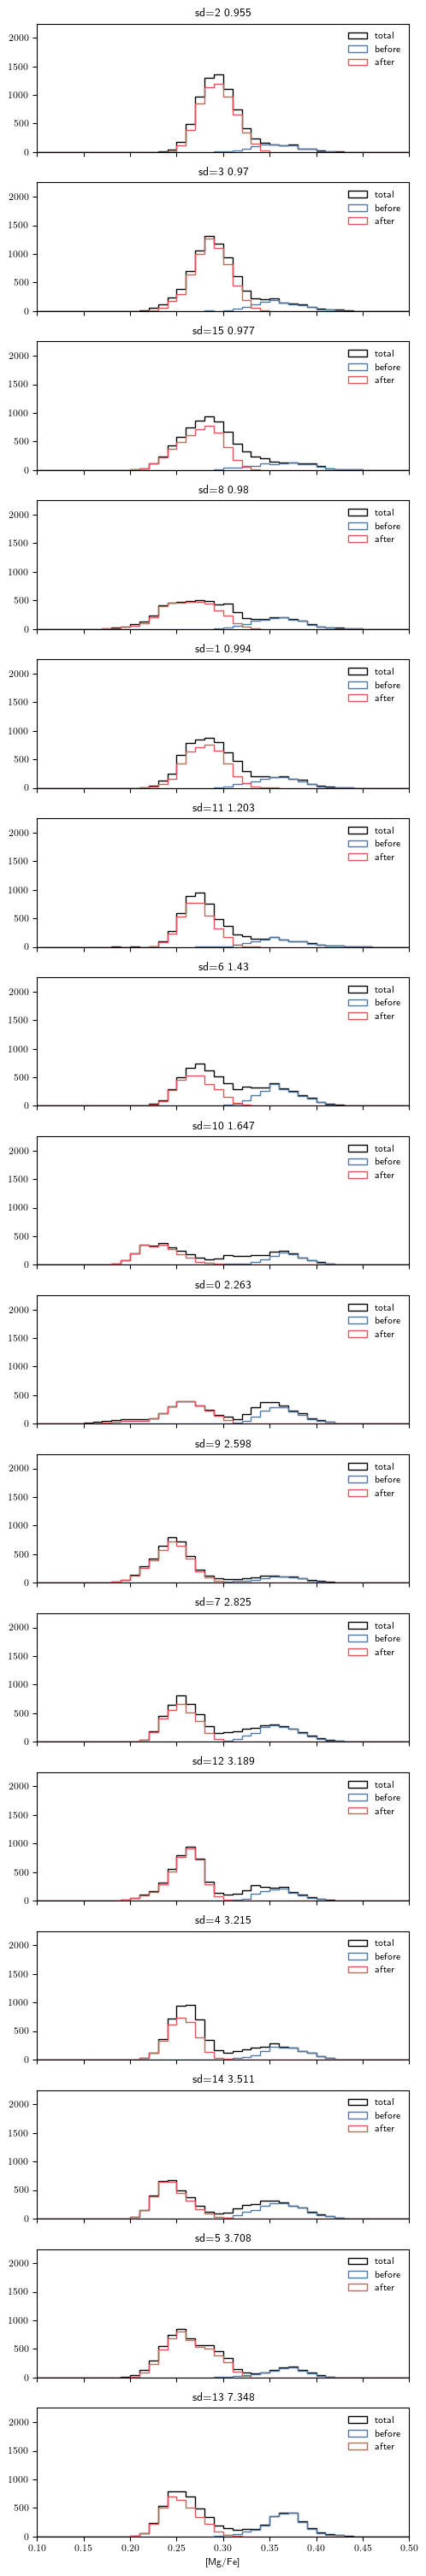

In [260]:
fig, axs = plt.subplots(16, 1, figsize=(1.5*columnwidth, 9*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.2

bins = np.arange(0.1, 0.5+0.01, 0.01)

for i,ax in enumerate(tqdm(axs)):
    sd = np.argsort(allscore)[i]
    
    dat = simdat[sd]
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    key = np.logical_and(key, tform < 4)
    
    key_before = np.logical_and(key, np.logical_and(tform > 1.2, tform < 2.2))
    key_during = np.logical_and(key, np.logical_and(tform > 2, tform < 3))
    key_after  = np.logical_and(key, np.logical_and(tform > 3, tform < 4))
    
    ax.hist(logMgFe[key],        histtype='step', color='k', bins=bins, label='total')
    ax.hist(logMgFe[key_before], histtype='step', color=tb_c[0], bins=bins, label='before')
    # ax.hist(logMgFe[key_during],  histtype='step', color=tb_c[1], bins=bins, label='during')
    ax.hist(logMgFe[key_after],  histtype='step', color=tb_c[2], bins=bins, label='after')
    ax.legend(frameon=False)
    ax.set_title('sd='+str(sd)+'  '+str(round(allscore[sd], 3)))
    
    
    
axs[0].set(xlim=(bins[0], bins[-1]), ylim=(0, 2250))
axs[-1].set(xlabel='[Mg/Fe]')

print(axs[0].get_ylim())

fig.tight_layout()
fig.savefig('MgFe_beforeafter.png')

In [191]:
# try unimodal

In [192]:
def load_galaxy_bysim(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [194]:
gal_uni = load_galaxy_bysim(('129', '116', '04'))
simdat_uni = extract_sim_data(gal_uni)

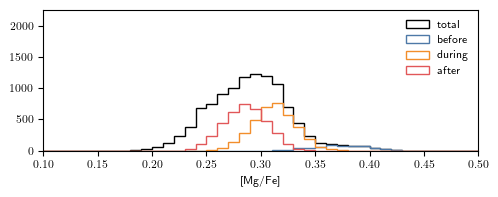

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(1.5*columnwidth, 0.6*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.2

bins = np.arange(0.1, 0.5+0.01, 0.01)

# for i,ax in enumerate(tqdm(axs)):
if True:
    dat = simdat_uni
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH/2., logFeH < logFeH0 + dlogFeH/2.)
    # key = np.logical_and(key, tform < 5)
    key_before = np.logical_and(key, np.logical_and(tform > 1, tform < 2))
    key_during = np.logical_and(key, np.logical_and(tform > 2, tform < 3))
    key_after  = np.logical_and(key, np.logical_and(tform > 3, tform < 4))
    
    ax.hist(logMgFe[key],        histtype='step', color='k', bins=bins, label='total')
    ax.hist(logMgFe[key_before], histtype='step', color=tb_c[0], bins=bins, label='before')
    ax.hist(logMgFe[key_during],  histtype='step', color=tb_c[1], bins=bins, label='during')
    ax.hist(logMgFe[key_after],  histtype='step', color=tb_c[2], bins=bins, label='after')
    ax.legend(frameon=False)
    
ax.set(xlim=(bins[0], bins[-1]), ylim=(0, 2250))
ax.set(xlabel='[Mg/Fe]')

fig.tight_layout()
# fig.savefig('MgFe_beforeafter.png')

In [204]:
import numpy as np

def average_logMgFe(dat, logFeH0, dlogFeH):
    """
    Computes the average logMgFe as a function of tform in bins of tform.

    Parameters:
        dat (dict): Dictionary containing 'logFeH', 'logMgFe', and 'GFM_StellarFormationTime'.
        logFeH0 (float): Center of the logFeH range for selection.
        dlogFeH (float): Width of the logFeH range for selection.

    Returns:
        tuple: Arrays of bin centers and average logMgFe values in each bin.
    """
    # Extract the required data
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    # Define the selection key
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    
    # Filter the data using the key
    selected_logMgFe = logMgFe[key]
    selected_tform = tform[key]
    
    # Define bins for tform
    bins = np.arange(0, 8.1, 0.1)  # Bins from 0 to 8 with width 0.1
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # Compute average logMgFe in each tform bin
    avg_logMgFe = []
    for i in range(len(bins) - 1):
        in_bin = np.logical_and(selected_tform >= bins[i], selected_tform < bins[i+1])
        if np.any(in_bin):  # Avoid division by zero
            avg_logMgFe.append(np.mean(selected_logMgFe[in_bin]))
        else:
            avg_logMgFe.append(np.nan)  # Handle empty bins
    
    return bin_centers, np.array(avg_logMgFe)

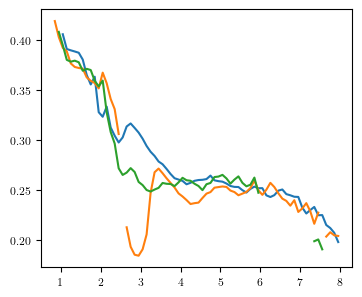

In [214]:
fig, ax = plt.subplots(1, 1, figsize=(1.2*columnwidth, columnwidth))

dat = simdat_uni
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

dat = simdat[0]
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

dat = simdat[13]
tplot, ave_logMgFe = average_logMgFe(dat, 0, 0.2)
ax.plot(tplot, ave_logMgFe)

In [242]:
allscore

array([2.2633666 , 0.99371277, 0.95507495, 0.97033037, 3.21486923,
       3.70849653, 1.43005041, 2.82485102, 0.97986842, 2.59772761,
       1.64665337, 1.20299349, 3.18897635, 7.34809158, 3.5109811 ,
       0.97724522])


100%|██████████| 16/16 [00:00<00:00, 106.89it/s]


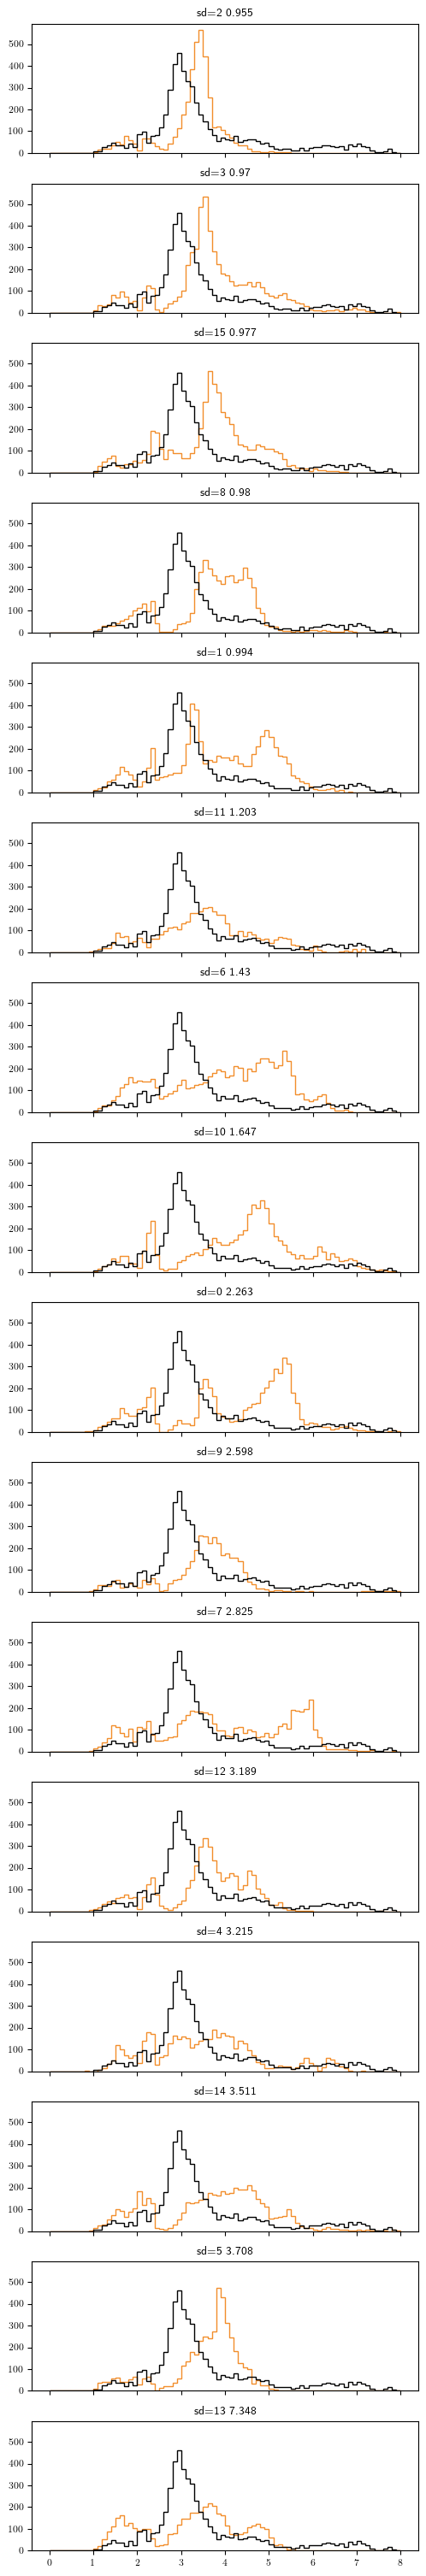

In [243]:
fig, axs = plt.subplots(16, 1, figsize=(1.5*columnwidth, 9*columnwidth), sharex=True, sharey=True)

logFeH0 = 0.
dlogFeH = 0.1

tbins = np.arange(0, 8+0.1, 0.1)

for i,ax in enumerate(tqdm(axs)):
    sd = np.argsort(allscore)[i]
    
    dat = simdat[sd]
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    ax.hist(tform[key], bins=tbins, histtype='step', color=tb_c[1])
    
    dat = simdat_uni
    logFeH = dat['logFeH']
    logMgFe = dat['logMgFe']
    tform = dat['GFM_StellarFormationTime']
    
    key = np.logical_and(logFeH > logFeH0 - dlogFeH / 2., logFeH < logFeH0 + dlogFeH / 2.)
    ax.hist(tform[key], bins=tbins, histtype='step', color='k')
    
    ax.set_title('sd='+str(sd)+'  '+str(round(allscore[sd], 3)))
    
fig.tight_layout()

# alpha/Fe - Fe/H plane movie

In [268]:
def plot_fig1(data, vmax=4e5):
    fig, ax = plt.subplots(1, 1, figsize=(columnwidth, 0.8*columnwidth))
    
    logFeH_lim  = (-1, 0.5)
    logMgFe_lim = (0.1, 0.65)

    N_FeH = 125
    N_MgFe = 125
    
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    tform = data['GFM_StellarFormationTime']
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
    wts = np.ones(len(logFeH))/dFeH/dMgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins])

    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, cmap='Greys', vmin=0, vmax=vmax)
    
    ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    ax.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax.set(aspect='auto')
    
    axs[0].set_xticks(np.arange(-1, 0.5+0.1, 0.1), minor=True)
    axs[0].set_yticks(np.arange(0.1, 0.7+0.1, 0.1))
    
    fig.tight_layout()
    
    return fig, ax

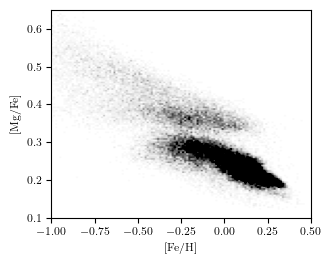

In [269]:
fig, ax = plot_fig1(simdat[0])

In [294]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.stats import binned_statistic_2d

def plot_fig1(data, vmax=1e5):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4.8))  # Adjust figure size as needed
    
    logFeH_lim  = (-1, 0.5)
    logMgFe_lim = (0.1, 0.65)

    N_FeH = 75
    N_MgFe = 75
    
    logFeH = data['logFeH']
    logMgFe = data['logMgFe']
    
    FeH_bins  = np.linspace(logFeH_lim[0],  logFeH_lim[1],  N_FeH+1)
    MgFe_bins = np.linspace(logMgFe_lim[0], logMgFe_lim[1], N_MgFe+1)
    dFeH  = (logFeH_lim[1]  - logFeH_lim[0] )/N_FeH
    dMgFe = (logMgFe_lim[1] - logMgFe_lim[0])/N_MgFe
        
    wts = np.ones(len(logFeH))/dFeH/dMgFe
    H, _, _, _ = binned_statistic_2d(logFeH, logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins])

    extent = [logFeH_lim[0], logFeH_lim[1], logMgFe_lim[0], logMgFe_lim[1]]
    im = ax.imshow(H.T, origin='lower', extent=extent, cmap='Greys', vmin=0, vmax=vmax)
    
    ax.set(xlim=logFeH_lim, ylim=logMgFe_lim)
    # ax.set(xlabel=r'$[\textrm{Fe}/\textrm{H}]$', ylabel=r'$[\textrm{Mg}/\textrm{Fe}]$')
    ax.set(aspect='auto')
    ax.set_xticks(np.arange(-1, 0.6, 0.1), minor=True)
    ax.set_yticks(np.arange(0.1, 0.8, 0.1))
    
    fig.tight_layout()
    
    return fig, ax, im

def make_movie(data, filename='tform_movie.mp4', fps=8, title=None):
    # Parameters
    tform = data['GFM_StellarFormationTime']
    tform_bins = np.arange(0, 8.025, 0.05)  # tform from 0 to 8, steps of 0.05
    bin_width = 0.1  # Each frame shows a bin width of 0.1

    fig, ax, im = plot_fig1(data)
    time_text = ax.text(0.05, 0.95, '', transform=ax.transAxes, fontsize=12, color='red', ha='left', va='top')
    if title is not None:
        ax.set_title(title)
    
    # add line separating the two sequences
    x = np.linspace(-1, 0.5, 1000)
    y = -0.1*x + 0.31
    ax.plot(x, y, c='k', ls='dashed')

    def update(frame):
        # Define tform range for this frame
        tform_min = tform_bins[frame]
        tform_max = tform_min + bin_width
        time_text.set_text(r'${:.2f} \leq \mathrm{{tform}} < {:.2f}$'.format(tform_min, tform_max))

        # Mask data based on tform range
        mask = np.logical_and(tform >= tform_min, tform < tform_max)
        masked_logFeH = data['logFeH'][mask]
        masked_logMgFe = data['logMgFe'][mask]
    
        # Create 2D histogram for masked data
        FeH_bins = np.linspace(-1, 0.5, 126)
        MgFe_bins = np.linspace(0.1, 0.65, 126)
        dFeH = 1.5 / 125
        dMgFe = 0.55 / 125
    
        if len(masked_logFeH) > 0:
            wts = np.ones(len(masked_logFeH)) / dFeH / dMgFe
            H, _, _, _ = binned_statistic_2d(
                masked_logFeH, masked_logMgFe, wts, statistic='sum', bins=[FeH_bins, MgFe_bins]
            )
        else:
            H = np.zeros((125, 125))
    
        # Update image
        im.set_data(H.T)
        return im, time_text


    # Create animation
    num_frames = len(tform_bins) - 1
    # num_frames = 80
    if 'seed0' in title:
        itr = tqdm(np.arange(num_frames), position=0, leave=True)
    else:
        itr = np.arange(num_frames)
    anim = FuncAnimation(fig, update, itr, blit=True)

    # Save as video
    anim.save(filename, writer='ffmpeg', fps=fps)
    plt.close(fig)


In [295]:
Parallel(n_jobs=16)(delayed(make_movie)(simdat[sd], title='seed'+str(sd)+'  '+str(round(allscore[sd],3)),
                                        filename='tform_movie/tform_movie_seed'+str(sd)+'.mp4', 
                                        fps=8) for sd in range(16))

 99%|█████████▉| 158/160 [00:16<00:00,  9.84it/s]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [287]:
for sd in np.argsort(allscore):
    print(sd, allscore[sd])

2 0.9550749456529523
3 0.9703303681576784
15 0.9772452224023096
8 0.9798684161983926
1 0.9937127734883932
11 1.2029934855228865
6 1.4300504130934109
10 1.6466533721331276
0 2.263366604426497
9 2.5977276113025534
7 2.824851015183447
12 3.1889763494540615
4 3.2148692291548167
14 3.5109811026338025
5 3.7084965348953793
13 7.348091576754982
